In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
%matplotlib notebook

def loadData():
    with np.load('notMNIST.npz') as data :
        Data, Target = data ['images'], data['labels']
        posClass = 2
        negClass = 9
        dataIndx = (Target==posClass) + (Target==negClass)
        Data = Data[dataIndx]/255.
        Target = Target[dataIndx].reshape(-1, 1)
        Target[Target==posClass] = 1
        Target[Target==negClass] = 0
        np.random.seed(421)
        randIndx = np.arange(len(Data))
        np.random.shuffle(randIndx)
        Data, Target = Data[randIndx], Target[randIndx]
        trainData, trainTarget = Data[:3500], Target[:3500]
        validData, validTarget = Data[3500:3600], Target[3500:3600]
        testData, testTarget = Data[3600:], Target[3600:]
    return trainData, validData, testData, trainTarget, validTarget, testTarget


def MSE(W, b, x, y, reg):
    x_0 = x.shape[0]
    x_1 = x.shape[1] * x.shape[2]
    W_reshape = W.reshape((x_1, 1))
    X_reshape = x.reshape((x_0, x_1))
    WX = np.matmul(X_reshape, W_reshape)
    cost = WX + b - y
    cost = np.sum(cost * cost) / (2 * x_0)
    regularization = np.matmul(W_reshape.transpose(), W_reshape) * reg / 2
    return np.sum(cost + regularization)

def gradMSE(W, b, x, y, reg):
    x_0 = x.shape[0]
    x_1 = x.shape[1]*x.shape[2]
    W_reshape = W.reshape((x_1, 1))
    X_reshape = x.reshape((x_0, x_1))
    e_in = np.matmul(X_reshape, W_reshape) + b - y
    grad_W = np.matmul(X_reshape.transpose(), e_in) / x_0 + reg * W_reshape
    grad_b = np.sum(e_in) / x_0
    return grad_W.reshape((x.shape[1], x.shape[2])), grad_b

def crossEntropyLoss(W, b, x, y, reg):
    x_0 = x.shape[0]
    x_1 = x.shape[1]*x.shape[2]
    W_reshape = W.reshape((x_1, 1))
    X_reshape = x.reshape((x_0, x_1))
    xn = np.matmul(X_reshape, W_reshape) + b
    sigmoid = 1 / (1 + np.exp((-1)*xn))
    cross_entropy = np.sum(((-1) * y * np.log(sigmoid) - (1 - y) * np.log(1 - sigmoid)))
    cross_entropy /= x_0
    regularization = np.matmul(W_reshape.transpose(), W_reshape)*reg/2
    return np.sum(cross_entropy+regularization)

def gradCE(W, b, x, y, reg):
    x_0 = x.shape[0]
    x_1 = x.shape[1]*x.shape[2]
    W_reshape = W.reshape((x_1, 1))
    X_reshape = x.reshape((x_0, x_1))
    xn = np.matmul(X_reshape, W_reshape) + b
    sigmoid = (1 / (1 + np.exp(xn)))
    e_in = (-1)*y*sigmoid + (1 - y)*sigmoid*np.exp(xn)
    grad_W = np.matmul(X_reshape.transpose(), e_in)/x_0 + reg*W_reshape
    grad_b = np.sum(e_in)/x_0
    return grad_W.reshape((x.shape[1], x.shape[2])), grad_b

def MSE_predict(W, b, x):
    x_0 = x.shape[0]
    x_1 = x.shape[1]*x.shape[2]
    W_reshape = W.reshape((x_1, 1))
    X_reshape = x.reshape((x_0, x_1))
    y_hat = np.matmul(X_reshape, W_reshape) + b
    return y_hat

def CE_predict(W, b, x):
    x_0 = x.shape[0]
    x_1 = x.shape[1]*x.shape[2]
    W_reshape = W.reshape((x_1, 1))
    X_reshape = x.reshape((x_0, x_1))
    y = np.matmul(X_reshape, W_reshape) + b
    y_hat = 1 / (1 + np.exp((-1) * y))
    return y_hat

def cal_accuracy(y_hat, y):
    correct = 0
    for i in range(y.shape[0]):
        if (y_hat[i] > 0.5 and y[i] == 1) or (y_hat[i] < 0.5 and y[i] == 0):
            correct += 1
    return correct/y.shape[0]

def grad_descent(W, b, trainingData, trainingLabels, validData, validLabels, testData, testLabels, alpha, iterations, reg, EPS, lossType):
    i = 0
    iter = []
    train_error = []
    valid_error = []
    test_error = []
    train_accuracy = []
    valid_accuracy = []
    test_accuracy = []
    train_e = 0
    valid_e = 0
    error_e = 0
    train_acc = 0
    valid_acc = 0
    test_acc = 0
    b_grad = None
    W_grad = None
    error = float("inf")
    while i < iterations and abs(error - train_e) >= EPS:
        error = train_e
        if lossType == "MSE":
            train_e = MSE(W, b, trainingData, trainingLabels, reg)
            valid_e = MSE(W, b, validData, validLabels, reg)
            error_e = MSE(W, b, testData, testLabels, reg)
            train_acc = cal_accuracy(MSE_predict(W, b, trainingData), trainingLabels)
            valid_acc = cal_accuracy(MSE_predict(W, b, validData), validLabels)
            test_acc = cal_accuracy(MSE_predict(W, b, testData), testLabels)
            W_grad, b_grad = gradMSE(W, b, trainingData, trainingLabels, reg)
        elif lossType == "CE":
            train_e = crossEntropyLoss(W, b, trainingData, trainingLabels, reg)
            valid_e = crossEntropyLoss(W, b, validData, validLabels, reg)
            error_e = crossEntropyLoss(W, b, testData, testLabels, reg)
            train_acc = cal_accuracy(CE_predict(W, b, trainingData), trainingLabels)
            valid_acc = cal_accuracy(CE_predict(W, b, validData), validLabels)
            test_acc = cal_accuracy(CE_predict(W, b, testData), testLabels)
            W_grad, b_grad = gradCE(W, b, trainingData, trainingLabels, reg)
        W = W - alpha * W_grad
        b = b - alpha * b_grad
        iter.append(i)
        train_error.append(train_e)
        valid_error.append(valid_e)
        test_error.append(error_e)
        train_accuracy.append(train_acc)
        valid_accuracy.append(valid_acc)
        test_accuracy.append(test_acc)
        i += 1
        print("TrainData: The iteration " + str(i) + " error: " + str(train_e) + " accuracy: " + str(train_acc))
        print("ValidData: The iteration " + str(i) + " error: " + str(valid_e) + " accuracy: " + str(valid_acc))
        print("testData: The iteration " + str(i) + " error: " + str(error_e) + " accuracy: " + str(test_acc))
    return train_error, valid_error, test_error, train_accuracy, valid_accuracy, test_accuracy, W, b

def figPlot(figureNumber,datas, title,yLabel): 
    f = plt.figure(figureNumber)
    plt.xlabel('Iterations')
    title = title 
    plt.title(title)  
    plt.ylabel(yLabel)
    labels =[]
    for Value, Data in datas.items(): 
        plt.plot(Data) 
        labels.append(Value) 
    plt.legend(labels, ncol = len(labels))
    f.show()
    plt.savefig(str(figureNumber))

trainData, validData, testData, trainTarget, validTarget, testTarget = loadData()
w = np.zeros((trainData.shape[1], trainData.shape[2]))
b = 1



In [ ]:
train1, valid1, test1, atrain1, avalid1, atest1, W1, b1= grad_descent(w, b, trainData, trainTarget, validData, validTarget, testData, testTarget, 0.005, 5000, 0, 1e-7, lossType="MSE")
figPlot(1,{"TrainData" : train1, "ValidData" : valid1, "TestData" : test1},"Error with alpha: 0.005, lambda: 0, iterations: 5000","Error")
figPlot(2,{"TrainData" : atrain1, "ValidData" : avalid1, "TestData" : atest1},"Accuracy with alpha: 0.005, lambda: 0, iterations: 5000","accuracy")
train2, valid2, test2, atrain2, avalid2, atest2, W2, b2= grad_descent(w, b, trainData, trainTarget, validData, validTarget, testData, testTarget, 0.001, 5000, 0, 1e-7, lossType="MSE")
figPlot(3,{"TrainData" : train2, "ValidData" : valid2, "TestData" : test2},"Error with alpha: 0.001, lambda: 0, iterations: 5000","Error")
figPlot(4,{"TrainData" : atrain2, "ValidData" : avalid2, "TestData" : atest2},"Accuracy with alpha: 0.001, lambda: 0, iterations: 5000","accuracy")
train3, valid3, test3, atrain3, avalid3, atest3, W3, b3= grad_descent(w, b, trainData, trainTarget, validData, validTarget, testData, testTarget, 0.0001, 5000, 0, 1e-7, lossType="MSE")
figPlot(5,{"TrainData" : train3, "ValidData" : valid3, "TestData" : test3},"Error with alpha: 0.0001, lambda: 0, iterations: 5000","Error")
figPlot(6,{"TrainData" : atrain3, "ValidData" : avalid3, "TestData" : atest3},"Accuracy with alpha: 0.0001, lambda: 0, iterations: 5000","accuracy")

In [7]:
def buildGraph(beta_1, beta_2, epsilon, lossType, learning_rate, optimizertype):
    #Initialize weight and bias tensors
    tf.set_random_seed(421)
    W = tf.Variable(tf.truncated_normal(shape = (1,784), stddev = 0.5, dtype = tf.float32))
    b = tf.Variable(1.0, dtype=tf.float32)
    X = tf.placeholder(tf.float32,[None, 784])
    Y = tf.placeholder(tf.float32, [None, 1])
    reg = tf.constant(0, tf.float32) 
    y_predicted = tf.matmul(X,tf.transpose(W)) + b
    regParamater = ((reg/2) * tf.matmul(W,tf.transpose(W)))
    
    if (lossType == "MSE"):
        loss = (1/2) * tf.reduce_mean(tf.squared_difference(y_predicted, Y)) + regParamater 
        if(optimizertype == 0):
            optimizer = tf.train.GradientDescentOptimizer(learning_rate = learning_rate)
        elif(optimizertype == 1):
            optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate, beta1 = beta_1, beta2 = beta_2, epsilon = epsilon)
        train = optimizer.minimize(loss)        
        return W, b, X, y_predicted, Y, loss, train, regParamater 
    
    elif (lossType == "CE"):       
        loss = tf.nn.sigmoid_cross_entropy_with_logits(labels=Y,logits=y_predicted) + regParamater
        if(optimizertype == 0):
            optimizer = tf.train.GradientDescentOptimizer(learning_rate = learning_rate)
        elif(optimizertype == 1):
            optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate, beta1 = beta_1, beta2 = beta_2, epsilon = epsilon)
        #optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate, beta1 = beta_1, beta2 = beta_2, epsilon = epsilon)
        train = optimizer.minimize(loss)
        return W, b, X, y_predicted, Y, loss, train, regParamater 
    
def trainTensorModel(epochs, inputData, outputLabels, validData, validTarget,testData, testTarget, lossType, batch_size, optimizertype):
    beta1 = 0.9
    beta2 = 0.999
    epsilon = 1e-4
    learning_rate = 0.001
    W, b, X, y_predicted, Y,error,train, reg = buildGraph(beta1, beta2, epsilon, lossType, learning_rate, optimizertype)
    init = tf.global_variables_initializer()
    X_1d = inputData.reshape(np.shape(inputData)[0],-1)
    sess = tf.InteractiveSession()
    sess.run(init)
    trainError = []
    trainAccuracy = []
    validError = []
    validAccuracy = []
    testError = []
    testAccuracy = []
    i = 0 
    for step in range(0, epochs):
        print(step)
        number_points = np.shape(inputData)[0]
        batches = int(number_points / batch_size)
        index = np.random.permutation(len(inputData))
        X_shuffled,Y_shuffled = X_1d[index], trainTarget[index]
        i = 0
        for k in range(batches):
            X_batch = X_shuffled[i:(i + batch_size),:] 
            y_batch = Y_shuffled[i:(i + batch_size),:]
            train_step, err, W_n, B_n, yhat = sess.run([train, error, W, b, y_predicted], feed_dict={X:X_batch, Y:y_batch}) 
            i = i + batch_size
        if(lossType == "MSE"):
            valid_loss = MSE(W_n, B_n, validData, validTarget, 0)
            test_loss = MSE(W_n, B_n, testData, testTarget, 0)
            valid_accuracy = 100 * cal_accuracy(MSE_predict(W_n, B_n, validData), validTarget)
            test_accuracy = 100 * cal_accuracy(MSE_predict(W_n, B_n, testData), testTarget)
        elif(lossType == "CE"):
            valid_loss = crossEntropyLoss(W_n, B_n, validData, validTarget, 0)
            test_loss = crossEntropyLoss(W_n, B_n, testData, testTarget, 0)
            valid_accuracy = 100 *cal_accuracy(CE_predict(W_n, B_n, validData), validTarget)
            test_accuracy = 100 * cal_accuracy(CE_predict(W_n, B_n, testData), testTarget)
        validError.append(valid_loss)
        testError.append(test_loss)
        validAccuracy.append(valid_accuracy)
        testAccuracy.append(test_accuracy)
        yhat_sign = tf.sign(tf.sign(yhat)+ 1)
        data_tf = tf.convert_to_tensor(y_batch, np.float32)
        t_prediction = tf.equal(data_tf, yhat_sign)
        accuracy = 100 * tf.reduce_mean(tf.cast(t_prediction, tf.float32))
        trainAccuracy.append(accuracy)
        trainError.append(err[0][0])  

    print("Final Training accuracy: ",sess.run(trainAccuracy[len(trainAccuracy) - 1])) 
    return trainError, sess.run([trainAccuracy]), validError, validAccuracy, testError, testAccuracy
    
trainData, validData, testData, trainTarget, validTarget, testTarget = loadData()

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

<IPython.core.display.Javascript object>


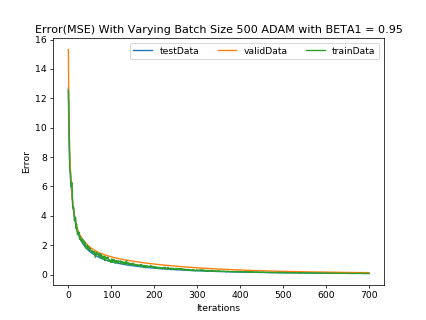

<IPython.core.display.Javascript object>


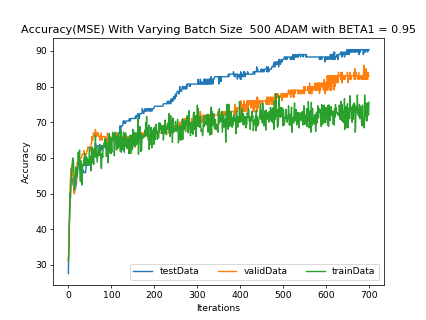

In [9]:
#figPlot(3,{"Training" : accuracy_training}, "Error" ,"Error") 
#figPlot(4,{"LR = 0.0001" : error_1,"LR = 0.001" : error_2,"LR = 0.005" : error_3}, "Training Data Error With Varying Learning Rates" ,"Error") 
error1, accuracy1, error2, accuracy2, error3, accuracy3 = trainTensorModel(700,trainData, trainTarget,validData, validTarget,testData, testTarget,"MSE",500, 1)
Length = len(error1) - 1
length1 = len(error2) -1
print("Final Training error:", error1[Length])
Length2 = len(error3) - 1
print("Final Validation accuracy:", accuracy2[len(accuracy2) -1])
print("Final Validation error:", error2[length1])
print("Final Test accuracy:", accuracy3[len(accuracy3) -1])
print("Final Test error:", error3[Length2])
figPlot(15,{"trainData" : error1, "validData" : error2, "testData" : error3},"Error(MSE) With Varying Batch Size 500 ADAM with BETA1 = 0.95","Error") #Creating a function to map out all of the graphs 
figPlot(16,{"trainData" : accuracy1[0], "validData" : accuracy2, "testData" : accuracy3},"Accuracy(MSE) With Varying Batch Size  500 ADAM with BETA1 = 0.95","Accuracy") #Creating a function to map out all of the graphs 

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

<IPython.core.display.Javascript object>


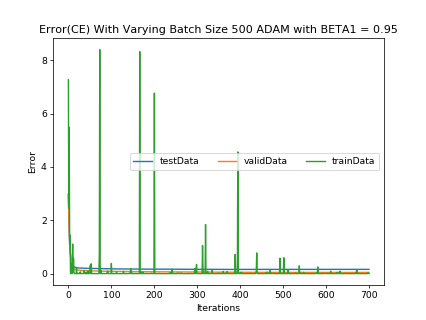

<IPython.core.display.Javascript object>


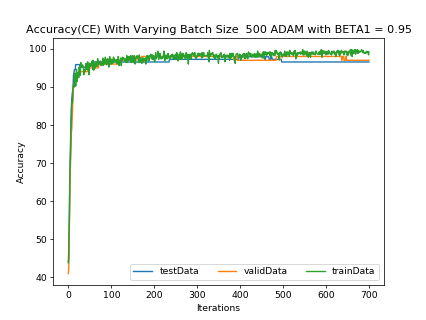

In [10]:
#figPlot(3,{"Training" : accuracy_training}, "Error" ,"Error") 
#figPlot(4,{"LR = 0.0001" : error_1,"LR = 0.001" : error_2,"LR = 0.005" : error_3}, "Training Data Error With Varying Learning Rates" ,"Error") 
error1, accuracy1, error2, accuracy2, error3, accuracy3 = trainTensorModel(700,trainData, trainTarget,validData, validTarget,testData, testTarget,"CE",500, 1)
Length = len(error1) - 1
length1 = len(error2) -1
print("Final Training error:", error1[Length])
Length2 = len(error3) - 1
print("Final Validation accuracy:", accuracy2[len(accuracy2) -1])
print("Final Validation error:", error2[length1])
print("Final Test accuracy:", accuracy3[len(accuracy3) -1])
print("Final Test error:", error3[Length2])
figPlot(17,{"trainData" : error1, "validData" : error2, "testData" : error3},"Error(CE) With Varying Batch Size 500 ADAM with BETA1 = 0.95","Error") #Creating a function to map out all of the graphs 
figPlot(18,{"trainData" : accuracy1[0], "validData" : accuracy2, "testData" : accuracy3},"Accuracy(CE) With Varying Batch Size  500 ADAM with BETA1 = 0.95","Accuracy") #Creating a function to map out all of the graphs 

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

<IPython.core.display.Javascript object>


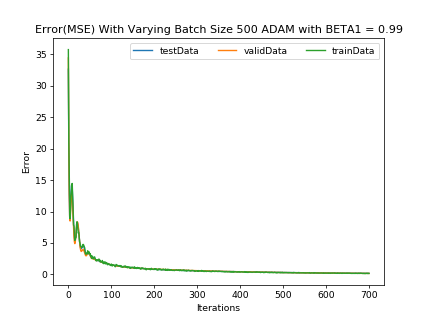

<IPython.core.display.Javascript object>


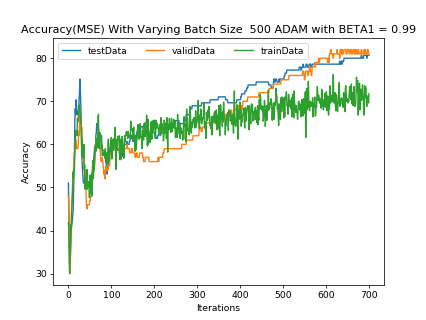

In [12]:
#figPlot(3,{"Training" : accuracy_training}, "Error" ,"Error") 
#figPlot(4,{"LR = 0.0001" : error_1,"LR = 0.001" : error_2,"LR = 0.005" : error_3}, "Training Data Error With Varying Learning Rates" ,"Error") 
error1, accuracy1, error2, accuracy2, error3, accuracy3 = trainTensorModel(700,trainData, trainTarget,validData, validTarget,testData, testTarget,"MSE",500, 1)
Length = len(error1) - 1
length1 = len(error2) -1
print("Final Training error:", error1[Length])
Length2 = len(error3) - 1
print("Final Validation accuracy:", accuracy2[len(accuracy2) -1])
print("Final Validation error:", error2[length1])
print("Final Test accuracy:", accuracy3[len(accuracy3) -1])
print("Final Test error:", error3[Length2])
figPlot(19,{"trainData" : error1, "validData" : error2, "testData" : error3},"Error(MSE) With Varying Batch Size 500 ADAM with BETA1 = 0.99","Error") #Creating a function to map out all of the graphs 
figPlot(20,{"trainData" : accuracy1[0], "validData" : accuracy2, "testData" : accuracy3},"Accuracy(MSE) With Varying Batch Size  500 ADAM with BETA1 = 0.99","Accuracy") #Creating a function to map out all of the graphs 

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

<IPython.core.display.Javascript object>


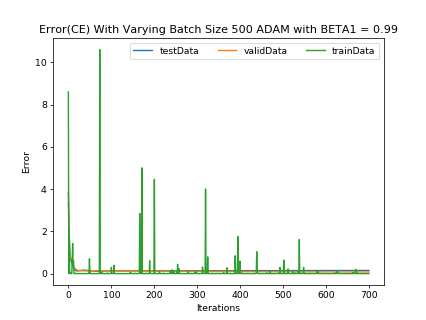

<IPython.core.display.Javascript object>


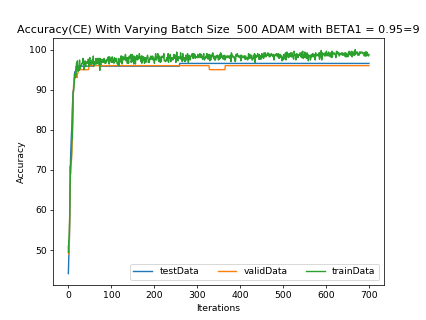

In [13]:
#figPlot(3,{"Training" : accuracy_training}, "Error" ,"Error") 
#figPlot(4,{"LR = 0.0001" : error_1,"LR = 0.001" : error_2,"LR = 0.005" : error_3}, "Training Data Error With Varying Learning Rates" ,"Error") 
error1, accuracy1, error2, accuracy2, error3, accuracy3 = trainTensorModel(700,trainData, trainTarget,validData, validTarget,testData, testTarget,"CE",500, 1)
Length = len(error1) - 1
length1 = len(error2) -1
print("Final Training error:", error1[Length])
Length2 = len(error3) - 1
print("Final Validation accuracy:", accuracy2[len(accuracy2) -1])
print("Final Validation error:", error2[length1])
print("Final Test accuracy:", accuracy3[len(accuracy3) -1])
print("Final Test error:", error3[Length2])
figPlot(21,{"trainData" : error1, "validData" : error2, "testData" : error3},"Error(CE) With Varying Batch Size 500 ADAM with BETA1 = 0.99","Error") #Creating a function to map out all of the graphs 
figPlot(22,{"trainData" : accuracy1[0], "validData" : accuracy2, "testData" : accuracy3},"Accuracy(CE) With Varying Batch Size  500 ADAM with BETA1 = 0.95=9","Accuracy") #Creating a function to map out all of the graphs 

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

<IPython.core.display.Javascript object>


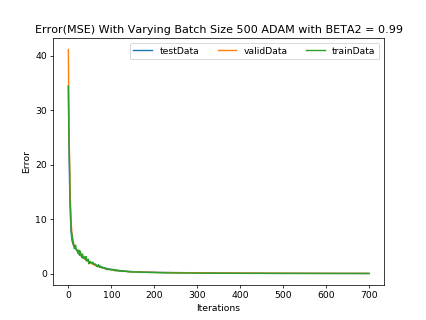

<IPython.core.display.Javascript object>


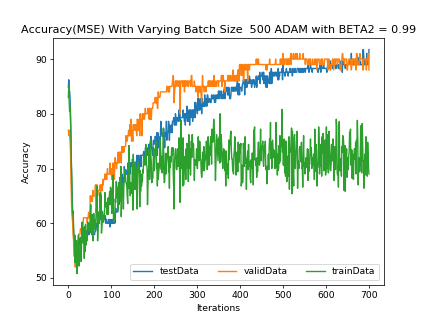

In [15]:
#figPlot(3,{"Training" : accuracy_training}, "Error" ,"Error") 
#figPlot(4,{"LR = 0.0001" : error_1,"LR = 0.001" : error_2,"LR = 0.005" : error_3}, "Training Data Error With Varying Learning Rates" ,"Error") 
error1, accuracy1, error2, accuracy2, error3, accuracy3 = trainTensorModel(700,trainData, trainTarget,validData, validTarget,testData, testTarget,"MSE",500, 1)
Length = len(error1) - 1
length1 = len(error2) -1
print("Final Training error:", error1[Length])
Length2 = len(error3) - 1
print("Final Validation accuracy:", accuracy2[len(accuracy2) -1])
print("Final Validation error:", error2[length1])
print("Final Test accuracy:", accuracy3[len(accuracy3) -1])
print("Final Test error:", error3[Length2])
figPlot(23,{"trainData" : error1, "validData" : error2, "testData" : error3},"Error(MSE) With Varying Batch Size 500 ADAM with BETA2 = 0.99","Error") #Creating a function to map out all of the graphs 
figPlot(24,{"trainData" : accuracy1[0], "validData" : accuracy2, "testData" : accuracy3},"Accuracy(MSE) With Varying Batch Size  500 ADAM with BETA2 = 0.99","Accuracy") #Creating a function to map out all of the graphs 

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

<IPython.core.display.Javascript object>


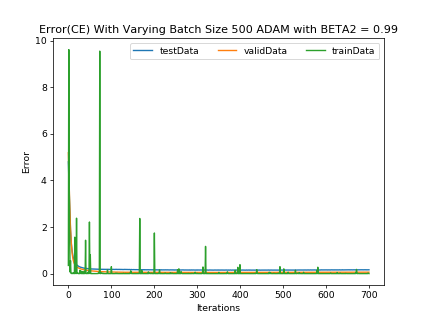

<IPython.core.display.Javascript object>


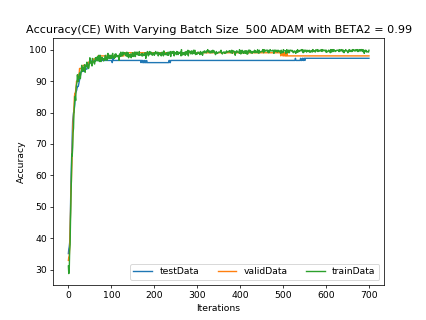

In [16]:
#figPlot(3,{"Training" : accuracy_training}, "Error" ,"Error") 
#figPlot(4,{"LR = 0.0001" : error_1,"LR = 0.001" : error_2,"LR = 0.005" : error_3}, "Training Data Error With Varying Learning Rates" ,"Error") 
error1, accuracy1, error2, accuracy2, error3, accuracy3 = trainTensorModel(700,trainData, trainTarget,validData, validTarget,testData, testTarget,"CE",500, 1)
Length = len(error1) - 1
length1 = len(error2) -1
print("Final Training error:", error1[Length])
Length2 = len(error3) - 1
print("Final Validation accuracy:", accuracy2[len(accuracy2) -1])
print("Final Validation error:", error2[length1])
print("Final Test accuracy:", accuracy3[len(accuracy3) -1])
print("Final Test error:", error3[Length2])
figPlot(25,{"trainData" : error1, "validData" : error2, "testData" : error3},"Error(CE) With Varying Batch Size 500 ADAM with BETA2 = 0.99","Error") #Creating a function to map out all of the graphs 
figPlot(26,{"trainData" : accuracy1[0], "validData" : accuracy2, "testData" : accuracy3},"Accuracy(CE) With Varying Batch Size  500 ADAM with BETA2 = 0.99","Accuracy") #Creating a function to map out all of the graphs 

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

<IPython.core.display.Javascript object>


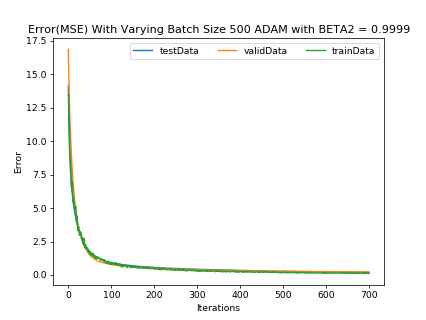

<IPython.core.display.Javascript object>


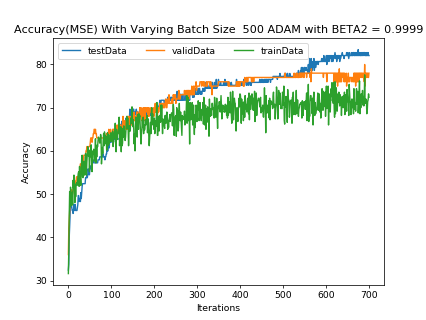

In [18]:
#figPlot(3,{"Training" : accuracy_training}, "Error" ,"Error") 
#figPlot(4,{"LR = 0.0001" : error_1,"LR = 0.001" : error_2,"LR = 0.005" : error_3}, "Training Data Error With Varying Learning Rates" ,"Error") 
error1, accuracy1, error2, accuracy2, error3, accuracy3 = trainTensorModel(700,trainData, trainTarget,validData, validTarget,testData, testTarget,"MSE",500, 1)
Length = len(error1) - 1
length1 = len(error2) -1
print("Final Training error:", error1[Length])
Length2 = len(error3) - 1
print("Final Validation accuracy:", accuracy2[len(accuracy2) -1])
print("Final Validation error:", error2[length1])
print("Final Test accuracy:", accuracy3[len(accuracy3) -1])
print("Final Test error:", error3[Length2])
figPlot(27,{"trainData" : error1, "validData" : error2, "testData" : error3},"Error(MSE) With Varying Batch Size 500 ADAM with BETA2 = 0.9999","Error") #Creating a function to map out all of the graphs 
figPlot(28,{"trainData" : accuracy1[0], "validData" : accuracy2, "testData" : accuracy3},"Accuracy(MSE) With Varying Batch Size  500 ADAM with BETA2 = 0.9999","Accuracy") #Creating a function to map out all of the graphs 

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

<IPython.core.display.Javascript object>


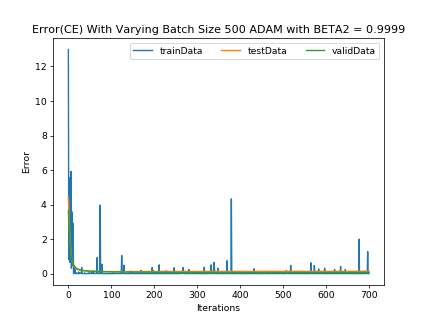

<IPython.core.display.Javascript object>


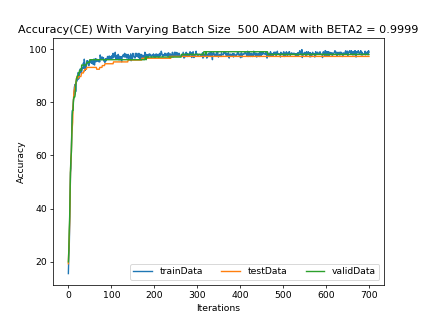

In [3]:
#figPlot(3,{"Training" : accuracy_training}, "Error" ,"Error") 
#figPlot(4,{"LR = 0.0001" : error_1,"LR = 0.001" : error_2,"LR = 0.005" : error_3}, "Training Data Error With Varying Learning Rates" ,"Error") 
error1, accuracy1, error2, accuracy2, error3, accuracy3 = trainTensorModel(700,trainData, trainTarget,validData, validTarget,testData, testTarget,"CE",500, 1)
Length = len(error1) - 1
length1 = len(error2) -1
print("Final Training error:", error1[Length])
Length2 = len(error3) - 1
print("Final Validation accuracy:", accuracy2[len(accuracy2) -1])
print("Final Validation error:", error2[length1])
print("Final Test accuracy:", accuracy3[len(accuracy3) -1])
print("Final Test error:", error3[Length2])
figPlot(29,{"trainData" : error1, "validData" : error2, "testData" : error3},"Error(CE) With Varying Batch Size 500 ADAM with BETA2 = 0.9999","Error") #Creating a function to map out all of the graphs 
figPlot(30,{"trainData" : accuracy1[0], "validData" : accuracy2, "testData" : accuracy3},"Accuracy(CE) With Varying Batch Size  500 ADAM with BETA2 = 0.9999","Accuracy") #Creating a function to map out all of the graphs 

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

<IPython.core.display.Javascript object>


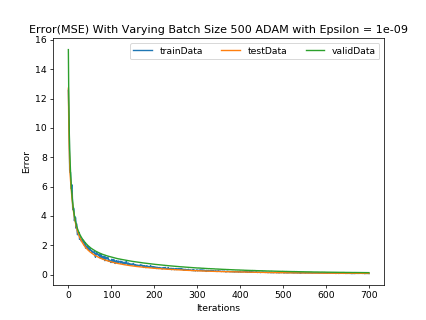

<IPython.core.display.Javascript object>


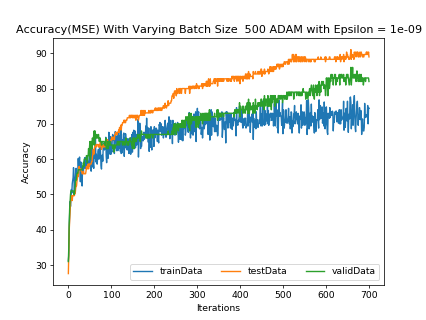

In [5]:
#figPlot(3,{"Training" : accuracy_training}, "Error" ,"Error") 
#figPlot(4,{"LR = 0.0001" : error_1,"LR = 0.001" : error_2,"LR = 0.005" : error_3}, "Training Data Error With Varying Learning Rates" ,"Error") 
error1, accuracy1, error2, accuracy2, error3, accuracy3 = trainTensorModel(700,trainData, trainTarget,validData, validTarget,testData, testTarget,"MSE",500, 1)
Length = len(error1) - 1
length1 = len(error2) -1
print("Final Training error:", error1[Length])
Length2 = len(error3) - 1
print("Final Validation accuracy:", accuracy2[len(accuracy2) -1])
print("Final Validation error:", error2[length1])
print("Final Test accuracy:", accuracy3[len(accuracy3) -1])
print("Final Test error:", error3[Length2])
figPlot(31,{"trainData" : error1, "validData" : error2, "testData" : error3},"Error(MSE) With Varying Batch Size 500 ADAM with Epsilon = 1e-09","Error") #Creating a function to map out all of the graphs 
figPlot(32,{"trainData" : accuracy1[0], "validData" : accuracy2, "testData" : accuracy3},"Accuracy(MSE) With Varying Batch Size  500 ADAM with Epsilon = 1e-09","Accuracy") #Creating a function to map out all of the graphs 

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

<IPython.core.display.Javascript object>


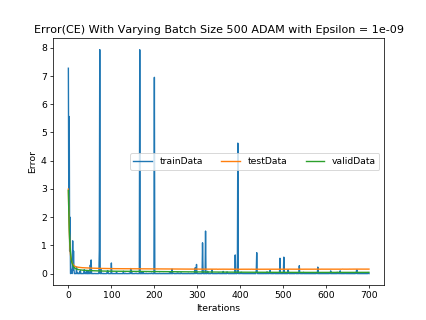

<IPython.core.display.Javascript object>


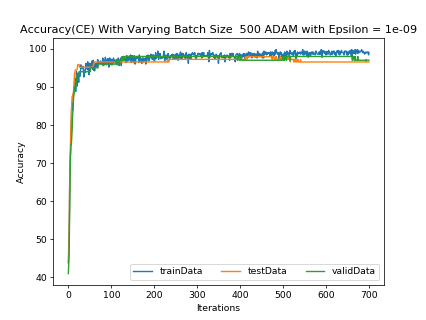

In [6]:
#figPlot(3,{"Training" : accuracy_training}, "Error" ,"Error") 
#figPlot(4,{"LR = 0.0001" : error_1,"LR = 0.001" : error_2,"LR = 0.005" : error_3}, "Training Data Error With Varying Learning Rates" ,"Error") 
error1, accuracy1, error2, accuracy2, error3, accuracy3 = trainTensorModel(700,trainData, trainTarget,validData, validTarget,testData, testTarget,"CE",500, 1)
Length = len(error1) - 1
length1 = len(error2) -1
print("Final Training error:", error1[Length])
Length2 = len(error3) - 1
print("Final Validation accuracy:", accuracy2[len(accuracy2) -1])
print("Final Validation error:", error2[length1])
print("Final Test accuracy:", accuracy3[len(accuracy3) -1])
print("Final Test error:", error3[Length2])
figPlot(33,{"trainData" : error1, "validData" : error2, "testData" : error3},"Error(CE) With Varying Batch Size 500 ADAM with Epsilon = 1e-09","Error") #Creating a function to map out all of the graphs 
figPlot(34,{"trainData" : accuracy1[0], "validData" : accuracy2, "testData" : accuracy3},"Accuracy(CE) With Varying Batch Size  500 ADAM with Epsilon = 1e-09","Accuracy") #Creating a function to map out all of the graphs 

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

<IPython.core.display.Javascript object>


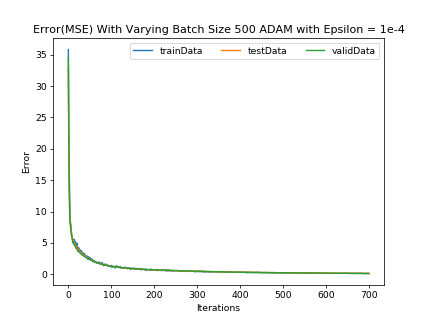

<IPython.core.display.Javascript object>


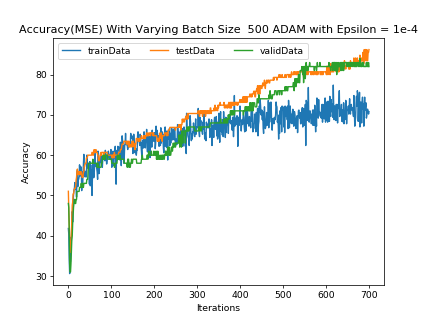

In [8]:
#figPlot(3,{"Training" : accuracy_training}, "Error" ,"Error") 
#figPlot(4,{"LR = 0.0001" : error_1,"LR = 0.001" : error_2,"LR = 0.005" : error_3}, "Training Data Error With Varying Learning Rates" ,"Error") 
error1, accuracy1, error2, accuracy2, error3, accuracy3 = trainTensorModel(700,trainData, trainTarget,validData, validTarget,testData, testTarget,"MSE",500, 1)
Length = len(error1) - 1
length1 = len(error2) -1
print("Final Training error:", error1[Length])
Length2 = len(error3) - 1
print("Final Validation accuracy:", accuracy2[len(accuracy2) -1])
print("Final Validation error:", error2[length1])
print("Final Test accuracy:", accuracy3[len(accuracy3) -1])
print("Final Test error:", error3[Length2])
figPlot(35,{"trainData" : error1, "validData" : error2, "testData" : error3},"Error(MSE) With Varying Batch Size 500 ADAM with Epsilon = 1e-4","Error") #Creating a function to map out all of the graphs 
figPlot(36,{"trainData" : accuracy1[0], "validData" : accuracy2, "testData" : accuracy3},"Accuracy(MSE) With Varying Batch Size  500 ADAM with Epsilon = 1e-4","Accuracy") #Creating a function to map out all of the graphs 

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

<IPython.core.display.Javascript object>


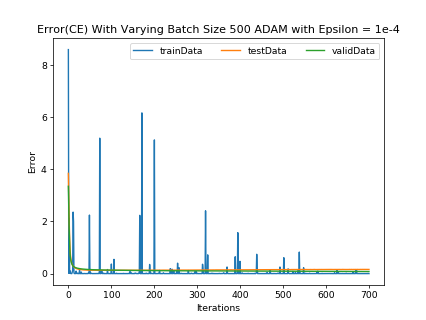

<IPython.core.display.Javascript object>


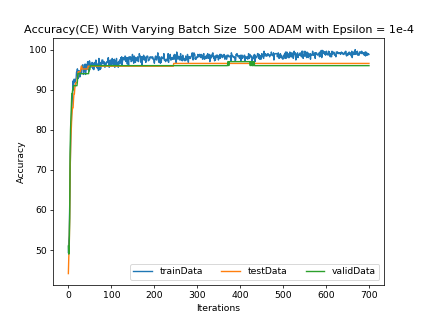

In [9]:
#figPlot(3,{"Training" : accuracy_training}, "Error" ,"Error") 
#figPlot(4,{"LR = 0.0001" : error_1,"LR = 0.001" : error_2,"LR = 0.005" : error_3}, "Training Data Error With Varying Learning Rates" ,"Error") 
error1, accuracy1, error2, accuracy2, error3, accuracy3 = trainTensorModel(700,trainData, trainTarget,validData, validTarget,testData, testTarget,"CE",500, 1)
Length = len(error1) - 1
length1 = len(error2) -1
print("Final Training error:", error1[Length])
Length2 = len(error3) - 1
print("Final Validation accuracy:", accuracy2[len(accuracy2) -1])
print("Final Validation error:", error2[length1])
print("Final Test accuracy:", accuracy3[len(accuracy3) -1])
print("Final Test error:", error3[Length2])
figPlot(37,{"trainData" : error1, "validData" : error2, "testData" : error3},"Error(CE) With Varying Batch Size 500 ADAM with Epsilon = 1e-4","Error") #Creating a function to map out all of the graphs 
figPlot(38,{"trainData" : accuracy1[0], "validData" : accuracy2, "testData" : accuracy3},"Accuracy(CE) With Varying Batch Size  500 ADAM with Epsilon = 1e-4","Accuracy") #Creating a function to map out all of the graphs 